In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt  
from matplotlib import cm
from tqdm import tqdm   
import pandas as pd
import numpy as np
import os, sys, pdb
import torch, torchvision
import pickle
import time
import cv2
from PIL import Image
# from pykeops.torch import LazyTensor

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import models
from utils import *

In [3]:
# user hyperparams
test_pds_pkl_path = '/xxx/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut/testcsv_PneumTubeBal_pkl_CsvPneumLblPneum.pkl'

(array([62.]), array([-0.5,  0.5]), <BarContainer object of 1 artists>)

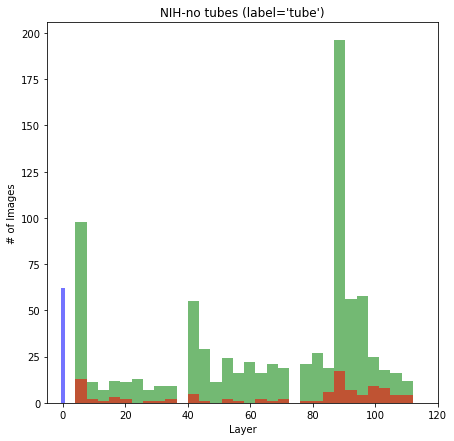

In [4]:
# plot PDs histogram
with open(test_pds_pkl_path, 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])

pred_cls = (batch_info['preds']>0.5).astype(int)
correct_preds_arr = (pred_cls==batch_info['labels'])
pos_pd_arr = (batch_info['pd']>=0)
batch_info['pd'][~pos_pd_arr] = 0


plt.figure(figsize=(7,7))
# plt.subplot(1,2,1)
plt.title("NIH-no tubes (label='tube')")
plt.ylabel('# of Images')
plt.xlabel('Layer')
plt.xlim((-5,120))
plt.hist(batch_info['pd'][correct_preds_arr & pos_pd_arr],bins=30,color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr & pos_pd_arr],bins=30,color='r',alpha=0.55)
plt.hist(batch_info['pd'][~pos_pd_arr],bins=1,color='b',alpha=0.55)
# plt.subplot(1,2,2)
# # plt.hist(batch_info['pd'][~pos_pd_arr],bins=30,color='b',alpha=0.55)
# plt.xlim((-5,5))
# plt.bar(0,len(batch_info['pd'][~pos_pd_arr]))

In [5]:
batch_info.keys()

dict_keys(['readme', 'paths', 'preds', 'labels', 'pd', 'layers_knn_mean', 'layers_knn_mode'])

In [6]:
len((batch_info['pd']==4).nonzero()[0]), len((batch_info['pd']==40).nonzero()[0]), len((batch_info['pd']==88).nonzero()[0])

(111, 60, 213)

In [7]:
def compute_pred_depth(arr):
    last = arr[-1]
    p_depth = 4
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1))*4 + 4
            break
    
    return p_depth

In [8]:
batch_info['layers_knn_mean'][13]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [300]:
(batch_info['pd']==88).nonzero()[0]

array([  1,   5,   7,   8,  12,  14,  15,  23,  27,  37,  42,  47,  50,
        51,  52,  55,  58,  69,  84,  90,  95,  96,  98,  99, 101, 103,
       113, 118, 127, 132, 135, 139, 143, 144, 152, 153, 157, 160, 166,
       172, 175, 178, 182, 183, 187, 192, 195, 204, 206, 208, 217, 219,
       241, 244, 248, 249, 251, 281, 284, 291, 297, 300, 304, 305, 310,
       312, 319, 324, 325, 328, 330, 333, 334, 336, 352, 354, 357, 358,
       359, 365, 366, 367, 376, 384, 392, 394, 399, 402, 422, 423, 428,
       434, 436, 437, 457, 458, 468, 470, 471, 474, 477, 478, 484, 490,
       495, 499, 510, 511, 513, 523, 526, 527, 530, 531, 532, 537, 538,
       546, 547, 548, 550, 551, 559, 570, 571, 579, 580, 590, 599, 603,
       607, 616, 623, 632, 651, 654, 658, 663, 664, 670, 671, 679, 681,
       685, 686, 689, 690, 699, 702, 706, 707, 709, 717, 719, 722, 724,
       729, 731, 736, 738, 741, 744, 748, 753, 755, 761, 769, 780, 786,
       790, 792, 798, 803, 807, 816, 831, 838, 858, 859, 861, 86

In [ ]:
batch_info['paths'][3], batch_info['pd'][3]

In [385]:
img_path = batch_info['paths'][166]

In [386]:
def register_hooks(model, hook):
    
    for idx,layer in enumerate(model.features.denseblock1):
        if idx%2==0:
            layer.register_forward_hook(hook)
            break
        
    return model

def hook_feat_map(mod, inp, out):
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

In [387]:
ckpt_path = '/xxx/projects/augmentation_by_explanation_eccv22/Output/NIH/imgsize_128/nih_shortcut/NIH-densenet121-NIH_128-best-auc0.8326.pt'

feature_maps = []
model = torch.load(ckpt_path).to('cuda')
model = register_hooks(model, hook_feat_map)

In [388]:
class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')
    
transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((128,128)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(normalize())
    ])

In [389]:
# get the nearest K neighbours
K = 29
lp_norm = 1
train_embs_pkl_path = '/xxx/projects/shortcut_detection_and_mitigation/data/nih/layer_embeddings/imgsize_128/dnet121_128imgsize_pneumClf_29layers_nihValBalancedCsv_feats.pkl'
layer_id = 0

with Image.open(img_path) as img:
    with torch.no_grad():
        img = transforms(img).unsqueeze(0).to('cuda')
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)
        feature_maps = []
        out = torch.sigmoid(model(img))
        print(f'Model output: {out}')

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')
            
            X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
            X_j = info_dict['feats'][layer_id].unsqueeze(0)  # (1, 60000, 784) train set
            if lp_norm==2:
                D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
            elif lp_norm==1:
                D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
            else:
                raise('Invalid lp_norm in arguments!')

            ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
            lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
        
        print_memory_profile('Pickle batch processed')
        
        # free GPU memory
        del info_dict
        torch.cuda.empty_cache()
        print_memory_profile('After GPU memory freed') 

Model output: tensor([[0.0001]], device='cuda:0')
Model forward pass
31.74853515625 0.46875 0.07413530349731445


Pickle load
31.74853515625 5.927734375 5.846886157989502


Pickle batch processed
31.74853515625 6.650390625 5.846886157989502


After GPU memory freed
31.74853515625 0.806640625 0.43546342849731445




In [390]:
-ind_knn[0] # lp norms between my x_q and nbr(x_q)

tensor([[57534.2188, 57542.5391, 58886.9453, 59150.6367, 59891.7812, 60144.8320,
         60191.2031, 60594.8359, 60707.7109, 60903.5586, 60979.4922, 61011.7773,
         61082.8555, 61195.8867, 61338.2734, 61514.8438, 61548.9766, 61611.9766,
         61800.7344, 61812.2969, 61832.1953, 61880.5078, 61979.6133, 61997.6406,
         62144.7188, 62183.2734, 62253.0078, 62259.3906, 62312.7070]],
       device='cuda:0')

In [391]:
torch.median(-ind_knn[0]), torch.sort(-ind_knn[0])

(tensor(61338.2734, device='cuda:0'),
 torch.return_types.sort(
 values=tensor([[57534.2188, 57542.5391, 58886.9453, 59150.6367, 59891.7812, 60144.8320,
          60191.2031, 60594.8359, 60707.7109, 60903.5586, 60979.4922, 61011.7773,
          61082.8555, 61195.8867, 61338.2734, 61514.8438, 61548.9766, 61611.9766,
          61800.7344, 61812.2969, 61832.1953, 61880.5078, 61979.6133, 61997.6406,
          62144.7188, 62183.2734, 62253.0078, 62259.3906, 62312.7070]],
        device='cuda:0'),
 indices=tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]], device='cuda:0')))

In [392]:
X_i.shape, X_j.shape, D_ij.shape

(torch.Size([1, 1, 98304]), torch.Size([1, 984, 98304]), torch.Size([1, 984]))

In [393]:
nbr_inds = np.array(ind_knn[1][0].detach().cpu())
X_j = X_j.detach().cpu()

In [394]:
X_j[0,nbr_inds,:].shape, X_i.squeeze().shape

(torch.Size([29, 98304]), torch.Size([98304]))

In [395]:
X_i

tensor([[[ 0.0000,  0.4332,  0.4332,  ..., -1.8866, -0.8493, -1.1903]]],
       device='cuda:0')

In [396]:
feature_maps[0].shape

torch.Size([1, 98304])

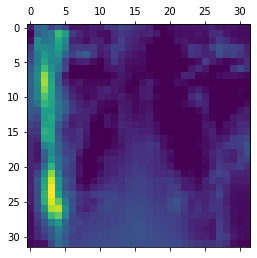

In [397]:
nbr_inds = np.array(ind_knn[1][0].detach().cpu())
nbr_feats = X_j[0,nbr_inds,:].to('cuda')
nbr_labels = lab_knn.squeeze()
s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick

model = torch.load(ckpt_path).to('cuda')

with Image.open(img_path) as img:
    model.eval()
    
    # pre-process the img to make it compatible for forward pass
    img = transforms(img).unsqueeze(0).to('cuda')
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)
        
    # custom forward pass
    out, img_feat = model.gradcam_forward(img,nbr_feats,nbr_labels,s)

    # show intermediate gradcam
    out.backward()

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = img_feat.detach()

    # weight the channels by corresponding gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


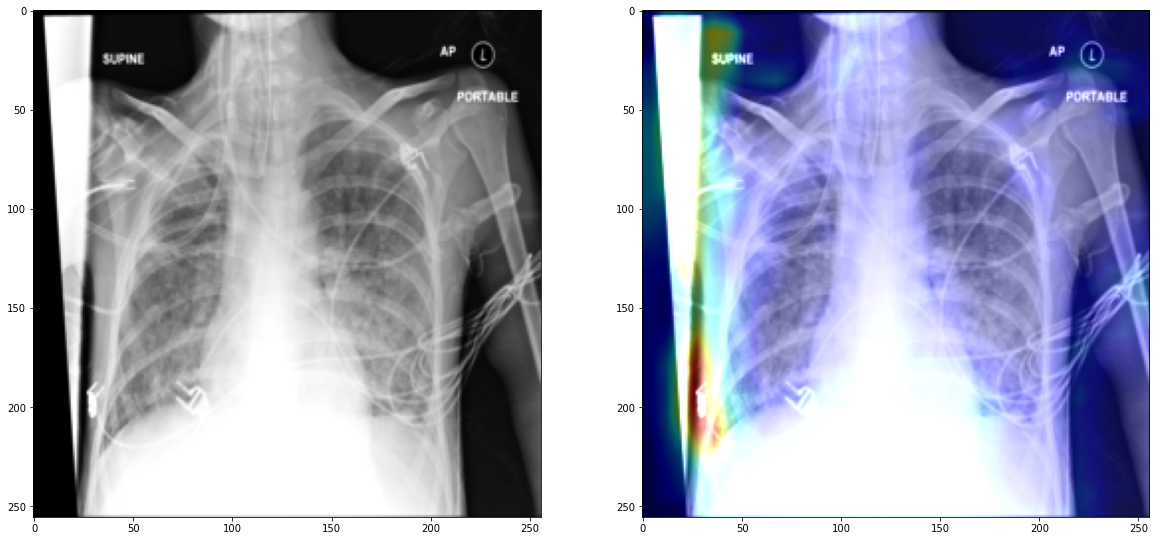

In [398]:
T1 = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1)),
    ])
with Image.open(img_path) as img:
    img = T1(img)
   
T2 = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(center_crop()),
    ])
heatmap = T2(heatmap)

jet = cm.get_cmap('jet')
heatmap2 = jet(heatmap.squeeze())

img2 = torch.cat((img,1.0*torch.ones(256,256).unsqueeze(0)))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(1.2*img2.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(1.2*img2.permute(1,2,0)+0.4*heatmap2)